# Permanent Income Model

#### Chase Coleman and Thomas Sargent


This notebook maps instances of the linear-quadratic-Gaussian permanent income model
with $\beta R = 1$ into a linear state space system, applies two different approaches to solving the model and compares outcomes from those two approaches. After confirming that answers produced by the two methods agree, it applies the quantecon [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class to illustrate various features of the model. 

Besides being a workhorse model for analyzing consumption data, the model is good for illustrating the concepts of

    * stationarity
    
    * ergodicity
    
    * ensemble moments and cross section observations
    
    * cointegration
           
    * linear-quadratic dynamic programming problems 
    
Background readings on the linear-quadratic-Gaussian permanent income model are Robert Hall's 1978 JPE paper ``Stochastic Implications of the Life Cycle-Permanent Income Hypothesis: Theory and Evidence'' and chapter 2 of [Recursive Macroeconomic Theory](https://mitpress.mit.edu/books/recursive-macroeconomic-theory-1)

    
Let's get started

In [1]:
import quantecon as qe
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(suppress=True, precision=4)

## Plan of the notebook

We study a version of the linear-quadratic-Gaussian model described in section 2.12 of chapter 2 of Ljungqvist and Sargent's [Recursive Macroeconomic Theory](https://mitpress.mit.edu/books/recursive-macroeconomic-theory-1)


We solve the model in two ways:

   * as an **LQ** dynamic programming problem, and
   
   * as a system of expectational difference equations with boundary conditions that advise us to solve stable roots  backwards and unstable roots forwards (see appendix A of chapter 2 of Ljungqvist and Sargent).
   
We confirm numerically that these two methods give rise to approximately the same solution. The  adverb approximately is appropriate because we use a technical trick to map the problem into a well behaved **LQ** dynamic programming problem.

## The model


The LQ permanent income model  is an example of a 
``savings problem.''
  A consumer has preferences over consumption streams
that are ordered by
the utility functional

$$ E_0 \sum_{t=0}^\infty \beta^t u(c_t),  \quad(1) $$

where $E_t$ is the mathematical expectation conditioned
on the consumer's time $t$ information,  $c_t$ is time $t$ consumption,
$u(c)$ is a strictly concave one-period utility function, and
$\beta \in (0,1)$ is a discount factor.  The LQ model gets its name partly from assuming that the
utility function $u$ is quadratic:

$$ u(c) = -.5(c - \gamma)^2 $$

where $\gamma>0$ is a bliss level of consumption.

The consumer maximizes
the utility functional (1) by choosing a consumption, borrowing plan
 $\{c_t, b_{t+1}\}_{t=0}^\infty$ subject to the sequence of budget constraints
 
$$ c_t + b_t = R^{-1} b_{t+1}  + y_t, t \geq 0,  \quad(2)  $$

where $y_t$ is an exogenous
 stationary endowment process, $R$ is a constant gross
risk-free interest rate, $b_t$ is one-period risk-free  debt  maturing at
$t$, and $b_0$ is a given initial condition.  We shall assume
that $R^{-1} = \beta$. Equation (2) is linear.  We use another set of linear equations
to model the endowment process.  In particular, we assume that the endowment
process has the state-space representation

$$ \eqalign{ z_{t+1} & = A_{22} z_t + C_2 w_{t+1}  \cr
               y_t & = U_y  z_t  \cr} \quad (3) $$
               
where $w_{t+1}$ is an i.i.d. process with mean zero and
identity contemporaneous covariance matrix, $A_{22}$ is a stable matrix,
its eigenvalues being strictly below unity in modulus, and
$U_y$ is a selection vector that identifies $y$ with a particular
linear combination of the $z_t$.

We impose the following condition on the
consumption, borrowing plan:

$$ E_0 \sum_{t=0}^\infty \beta^t b_t^2 < +\infty. \quad (4) $$

This condition suffices to rule out Ponzi schemes. (We impose this condition to
rule out a borrow-more-and-more plan that would allow the household to
enjoy bliss consumption forever.)

The state vector confronting the household at $t$  is
$$ x_t = \left[\matrix{z_t \cr b_t\cr}\right]',$$
where $b_t$ is its one-period debt falling
 due at the beginning of period $t$
and $z_t$ contains all variables useful for
forecasting its future endowment. 

We shall solve the problem two ways.  

  * First, as a linear-quadratic control dynamic programming problem that we can solve using the **LQ** class.
  
  * Second, as a set of expectational difference equations that we can solve with homemade programs.


### Solution as an LQ problem

We can map the problem into a linear-quadratic dynamic programming problem, also known
as an optimal linear regulator problem.  

The stochastic discounted linear optimal regulator problem is to
choose a decision rule for $u_t$ to
maximize

$$ - E_0\sum_{t=0}^\infty \beta^t \{x'_t Rx_t+u'_tQu_t\},\quad 0<\beta<1,$$

subject to $x_0$ given, and the law of motion

$$x_{t+1} = A x_t+ Bu_t+ C w_{t+1},\qquad t\geq 0, $$

where $w_{t+1}$ is an $(n\times 1)$ vector of random variables that is
independently and identically distributed according to the normal
distribution with mean vector zero and covariance matrix
$Ew_t w'_t= I .$

The value function for this problem is
$v(x)= - x'Px-d,$
where $P$ is the unique positive semidefinite solution of the discounted
algebraic matrix Riccati equation corresponding to the limit of iterations on matrix Riccati difference
equation 

$$P_{j+1} =R+\beta A'P_j A-\beta^2 A'P_jB(Q+\beta B'P_jB)^{-1} B'P_jA.$$

from $P_0=0$.  The optimal policy is $u_t=-Fx_t$, where $F=\beta (Q+\beta
B'PB)^{-1} B'PA$.
 The scalar $d$ is given by
$ d=\beta(1-\beta)^{-1} {\rm trace} ( P C C') . $

Under an optimal decision rule $F$, the state vector $x_t$ evolves according to

$$ x_{t+1} = (A-BF) x_t + C w_{t+1} $$



  

$$ \left[\matrix{z_{t+1} \cr b_{t+1} \cr}\right] = \left[\matrix{ A_{22} &  0 \cr                                         R(U_\gamma - U_y) & R } \right]\left[\matrix{z_{t} \cr b_{t} \cr}\right]   + 
    \left[\matrix{0 \cr R}\right] (c_t - \gamma) + \left[\matrix{ C_t \cr 0 } \right] w_{t+1} $$
or

$$ x_{t+1} = A x_t + B u_t + C w_{t+1} $$

We form the quadratic form $x_t' \bar R x_t + u_t'Q u_t $ with
$Q =1$ and $\bar R$ a $ 4 \times 4$ matrix with all elements zero except for a very small entry
$\alpha >0$ in the $(4,4)$ position.  (We put the $\bar \cdot$ over the $R$ to avoid ``recycling''
the $R$ notation!)






We begin by creating an instance of the state-space system (2) that governs the income $\{y_t\}$ process.  We assume 
it is a second order univariate autoregressive process:
$$ y_{t+1} = \alpha + \rho_1 y_t + \rho_2 y_{t-1} + \sigma w_{t+1} $$

In [2]:
# Possible parameters
#         alpha, beta, rho1, rho2, sigma
params = [[10.0, 0.95, 1.2, -0.3, 1.0],
          [10.0, 0.95, 0.9, 0.0, 1.0],
          [10.0, 0.95, 0.0, -0.0, 10.0]]
# Set parameters
alpha, beta, rho1, rho2, sigma = params[1]

#  Note: LinearStateSpace object runs into iteration limit in computing stationary variance when we set 
#  sigma = .5 -- replace with doublej2 to fix this. Do some more testing

R = 1/beta
A = np.array([[1., 0., 0.],
              [alpha, rho1, rho2],
              [0., 1., 0.]])
C = np.array([[0.], [sigma], [0.]])
G = np.array([[0., 1., 0.]])

# for later use, form LinearStateSpace system and pull off steady state moments
mu_z0 = np.array([[1.0], [0.0], [0.0]])
sig_z0 = np.zeros((3, 3))
Lz = qe.LinearStateSpace(A, C, G, mu_0=mu_z0, Sigma_0=sig_z0) 
muz, muy, Sigz, Sigy = Lz.stationary_distributions()

# mean vector of state for the savings problem
mxo = np.vstack([muz, 0.0])

# create stationary covariance matrix of x -- start everyone off at b=0
a1 = np.zeros((3, 1))
aa = np.hstack([Sigz, a1])
bb = np.zeros((1, 4))
sxo = np.vstack([aa, bb])

# These choices will initialize the state vector of an individual at zero debt
# and the ergodic distribution of the endowment process. Use these to create
# the Bewley economy.
mxbewley = mxo
sxbewley = sxo

It turns out that the bliss level of consumption $\gamma$ in the utility function $-.5 (c_t -\gamma)^2$
has no effect on the optimal decision rule. 
(We shall  see why below when we inspect the Euler equation for consumption.)

Now create the objects for the optimal linear regulator.

Here we will use a trick to induce the Bellman equation to respect restriction (4) on the debt sequence
$\{b_t\}$.  To accomplish that, we'll  put a very small penalty on $b_t^2$ in the criterion function.  

That will induce a (hopefully) small approximation error in the decision rule. We'll check whether it really is small numerically soon.

In [3]:
#
# Here we create the matrices for our system
#
A12 = np.zeros((3,1))
ALQ_l = np.hstack([A, A12])
ALQ_r = np.array([[0, -R, 0, R]])
ALQ = np.vstack([ALQ_l, ALQ_r])

RLQ = np.array([[0., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 1e-9]])

QLQ = np.array([1.0])
BLQ = np.array([0., 0., 0., R]).reshape(4,1)
CLQ = np.array([0., sigma, 0., 0.]).reshape(4,1)
betaLQ = beta

In [4]:
print("We can inspect the matrices that describe our system below")
print("A = \n", ALQ)
print("B = \n", BLQ)
print("R = \n", RLQ)
print("Q = \n", QLQ)

We can inspect the matrices that describe our system below
A = 
 [[  1.       0.       0.       0.    ]
 [ 10.       0.9      0.       0.    ]
 [  0.       1.       0.       0.    ]
 [  0.      -1.0526   0.       1.0526]]
B = 
 [[ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 1.0526]]
R = 
 [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
Q = 
 [ 1.]


Now create the appropriate  instance of an **LQ** model

In [5]:
LQPI = qe.LQ(QLQ, RLQ, ALQ, BLQ, C=CLQ, beta=betaLQ)

Now create the optimal policies using the analytic formulas.

We'll save the answers and will compare them with answers we get by employing an alternative solution method.


In [6]:
P, F, d = LQPI.stationary_values()  # Compute optimal value function and decision rule

ABF = ALQ - np.dot(BLQ,F)  #  Form closed loop system 

### Solution via a system of expectational difference equations

Now we will solve the household's optimum problem  by first deducing the *Euler equations* that are the first-order conditions with respect to consumption and savings, then  using the budget constraints and the boundary condition (4) to complete a system of expectational linear difference equations that we'll solve for the optimal consumption, debt plan.

First-order conditions for the problem are

$$ E_t u'(c_{t+1}) = u'(c_t) , \ \ \forall t \geq 0.  \quad (5) $$

In our linear-quadratic model, we assume
the quadratic  utility function
$u(c_t) =  -.5 (c_t - \gamma)^2$,
where $\gamma$ is a bliss level of consumption. Then the consumption Euler equation becomes
$$ E_t c_{t+1} = c_t . \quad (6) $$
Along  with the quadratic utility specification, we allow consumption
$c_t$ to be negative.

 To deduce the optimal decision rule, we want to solve the system
of difference equations formed by (2)  and  (6)
subject to the boundary condition (4).   To accomplish this,
solve (2) forward and impose $\lim_{T\rightarrow +\infty} \beta^T b_{T+1} =0$ to get
$$ b_t = \sum_{j=0}^\infty \beta^j (y_{t+j} - c_{t+j}) .  \quad (7) $$
Imposing $\lim_{T\rightarrow +\infty} \beta^T b_{T+1} =0$ suffices to impose (4) on the debt
path.
Take conditional expectations on both sides of (7) and use (6)
and the law of iterated expectations to deduce
$$ b_t = \sum_{j=0}^\infty \beta^j E_t y_{t+j} - {1 \over 1-\beta} c_t
\quad (8) $$
 or
$$ c_t = (1-\beta)
\left[ \sum_{j=0}^\infty \beta^j E_t y_{t+j} - b_t\right].
 \quad (9)  $$
If we define the net rate of interest $r$ by $\beta ={1 \over 1+r}$, we can
also express this
equation as
$$ c_t = {r \over 1+r}
\left[ \sum_{j=0}^\infty \beta^j E_t y_{t+j} - b_t\right]. \quad (10) $$
Equation (9) or (10)  asserts that *consumption* equals what Irving Fisher defined as 
*economic income*, namely,  a constant
marginal propensity to consume or interest factor ${r \over 1+r}$ times
the sum of *nonfinancial wealth* $
\sum_{j=0}^\infty \beta^j E_t y_{t+j}$ and *financial
wealth* $-b_t$.   Notice that (9) or (10) represents
$c_t$  as a function of the *state* $[b_t, z_t]$
 confronting the household, where  from  $z_t$ contains all
information useful for forecasting the endowment process.





Pulling together our preceding results, we can regard $z_t, b_t$ as
the time $t$ state, where $z_t$ is an *exogenous* component of the state
and $b_t$ is an *endogenous* component of the state vector. The system
can be represented as

$$ \eqalign{ z_{t+1} & = A_{22} z_t + C_2 w_{t+1} \cr
   b_{t+1} & = b_t + U_y [ (I -\beta A_{22})^{-1} (A_{22} - I) ] z_t \cr
   y_t & = U_y z_t \cr
   c_t & = (1-\beta) [ U_y(I-\beta A_{22})^{-1} z_t - b_t ].  \cr } \quad (11)  $$
   


Now we'll apply the formulas in equation system (11).

Later we shall use them to get objects needed to form the system (11) as an instance of a **LinearStateSpace** class that we'll use to exhibit features of the LQ permanent income model. 

In [7]:
# Use the above formulas to create the optimal policies for $b_{t+1}$ and $c_t$
b_pol = np.dot(G, la.inv(np.eye(3, 3) - beta*A)).dot(A - np.eye(3, 3))
c_pol = (1 - beta)*np.dot(G, la.inv(np.eye(3, 3) - beta*A))

#Create the A matrix for a LinearStateSpace instance
A_LSS1 = np.vstack([A, b_pol])
A_LSS2 = np.eye(4, 1, -3)
A_LSS = np.hstack([A_LSS1, A_LSS2])

# Create the C matrix for LSS methods
C_LSS = np.vstack([C, np.zeros(1)])

# Create the G matrix for LSS methods
G_LSS1 = np.vstack([G, c_pol])
G_LSS2 = np.vstack([np.zeros(1), -(1 - beta)])
G_LSS = np.hstack([G_LSS1, G_LSS2])

# use the following values to start everyone off at b=0, initial incomes zero

# Initial Conditions
mu_0 = np.array([1., 0., 0., 0.])
sigma_0 = np.zeros((4, 4))

A_LSS calculated as we have here should equal ABF calculated above using the LQ model.

Here comes the check.  The difference between ABF and A_LSS should be zero



In [8]:
ABF - A_LSS

array([[ 0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ],
       [-0.0001, -0.    ,  0.    ,  0.    ]])

Now compare pertinent elements of c_pol and -F

In [9]:
print(c_pol, "\n", -F)

[[ 65.5172   0.3448   0.    ]] 
 [[ 65.5172   0.3448  -0.      -0.05  ]]


We have verified that the two methods give the same solution.

Now let's create an instance of a **LinearStateSpace** model.

To do this, we'll use the outcomes from out second method.  

#### Two examples

Now we'll generate panels of consumers. We'll study two examples that are differentiated only by the initial states with which we endow consumers.  All other parameter values are kept the same in the two examples.  

* In the first example, all consumers begin with zero nonfinancial income and zero debt. The consumers are thus *ex ante* identical. 
* In the second example, consumers are *ex ante* heterogeneous. While all of them begin with zero debt, we draw their initial income levels from the invariant distribution of financial income.   
 
In the first example, consumers' nonfinancial income paths will display prounounced transients early in the sample that will affect outcomes in striking ways. Those transient effects will not be present in the second example.

 

Now we'll use methods that the **LinearStateSpace** class contains to simulate the model with our first set of intitial conditions. 

  * 25 paths of the exogenous non-financial income process and the associated consumption and debt paths.  In the first set of graphs, the darker lines depict one particular sample path, while the lighter lines indicate the other 24 paths.
  
  * A second graph that plots a collection of simulations against the population distribution that we extract from the **LinearStateSpace** instance LSS

In [10]:
LSS = qe.LinearStateSpace(A_LSS, C_LSS, G_LSS, mu_0=mu_0, Sigma_0=sigma_0)

### Population and sample panels 

In the code below, we use the *LinearStateSpace* class to 

  * compute and plot population quantiles of the distributions of consumption and debt for a population of consumers
  
  * simulate a group of 25 consumers and plot sample paths on the same graph as the population distribution 

In [11]:
def income_consumption_debt_series(A, C, G, m0, s0, T=150, npaths=25):
    """
    This function takes initial conditions (m0, s0) and uses the Linear State Space
    class from QuantEcon to  simulate an economy `npaths` times for `T` periods.
    It then uses that information to generate some graphs related to the discussion
    below.
    """
    LSS = qe.LinearStateSpace(A, C, G, mu_0=m0, Sigma_0=s0)

    # Simulation/Moment Parameters
    moment_generator = LSS.moment_sequence()

    # Simulate various paths
    bsim = np.empty((npaths, T))
    csim = np.empty((npaths, T))
    ysim = np.empty((npaths, T))

    for i in range(npaths):
        sims = LSS.simulate(T)
        bsim[i, :] = sims[0][-1, :]
        csim[i, :] = sims[1][1, :]
        ysim[i, :] = sims[1][0, :]

    # Get the moments
    cons_mean = np.empty(T)
    cons_var = np.empty(T)
    debt_mean = np.empty(T)
    debt_var = np.empty(T)
    for t in range(T):
        mu_x, mu_y, sig_x, sig_y = next(moment_generator)
        cons_mean[t], cons_var[t] = mu_y[1], sig_y[1, 1]
        debt_mean[t], debt_var[t] = mu_x[3], sig_x[3, 3]
        
    return bsim, csim, ysim, cons_mean, cons_var, debt_mean, debt_var

def consumption_income_debt_figure(bsim, csim, ysim):
    
    # Get T
    T =  bsim.shape[1]
    
    # Create first figure
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    xvals = np.arange(T)
    
    # Plot consumption and income
    ax[0].plot(csim[0, :], label="c", color="b")
    ax[0].plot(ysim[0, :], label="y", color="g")
    ax[0].plot(csim.T, alpha=.1, color="b")
    ax[0].plot(ysim.T, alpha=.1, color="g")
    ax[0].legend(loc=4)
    ax[0].set_xlabel("t")
    ax[0].set_ylabel("y and c")

    # Plot debt
    ax[1].plot(bsim[0, :], label="b", color="r")
    ax[1].plot(bsim.T, alpha=.1, color="r")
    ax[1].legend(loc=4)
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("debt")

    fig.suptitle("Nonfinancial Income, Consumption, and Debt")
    
    return fig

def consumption_debt_fanchart(csim, cons_mean, cons_var,
                              bsim, debt_mean, debt_var):
    # Get T
    T =  bsim.shape[1]
    
    # Create Percentiles of cross-section distributions
    cmean = np.mean(cons_mean)
    c90 = 1.65*np.sqrt(cons_var)
    c95 = 1.96*np.sqrt(cons_var)
    c_perc_95p, c_perc_95m = cons_mean + c95, cons_mean - c95
    c_perc_90p, c_perc_90m = cons_mean + c90, cons_mean - c90

    # Create Percentiles of cross-section distributions
    dmean = np.mean(debt_mean)
    d90 = 1.65*np.sqrt(debt_var)
    d95 = 1.96*np.sqrt(debt_var)
    d_perc_95p, d_perc_95m = debt_mean + d95, debt_mean - d95
    d_perc_90p, d_perc_90m = debt_mean + d90, debt_mean - d90
    
    
    # Create second figure
    fig2, ax2 = plt.subplots(2, 1, figsize=(10, 8))
    xvals = np.arange(T)
    
    # Consumption fan
    ax2[0].plot(xvals, cons_mean, color="k")
    ax2[0].plot(csim.T, color="k", alpha=.25)
    ax2[0].fill_between(xvals, c_perc_95m, c_perc_95p, alpha=.25, color="b")
    ax2[0].fill_between(xvals, c_perc_90m, c_perc_90p, alpha=.25, color="r")
    ax2[0].set_ylim((cmean-15, cmean+15))
    ax2[0].set_ylabel("consumption")
    
    # Debt fan
    ax2[1].plot(xvals, debt_mean, color="k")
    ax2[1].plot(bsim.T, color="k", alpha=.25)
    ax2[1].fill_between(xvals, d_perc_95m, d_perc_95p, alpha=.25, color="b")
    ax2[1].fill_between(xvals, d_perc_90m, d_perc_90p, alpha=.25, color="r")
#     ax2[1].set_ylim()
    ax2[1].set_ylabel("debt")
    
    fig2.suptitle("Consumption/Debt over time")
    ax2[1].set_xlabel("t")
    
    
    return fig2

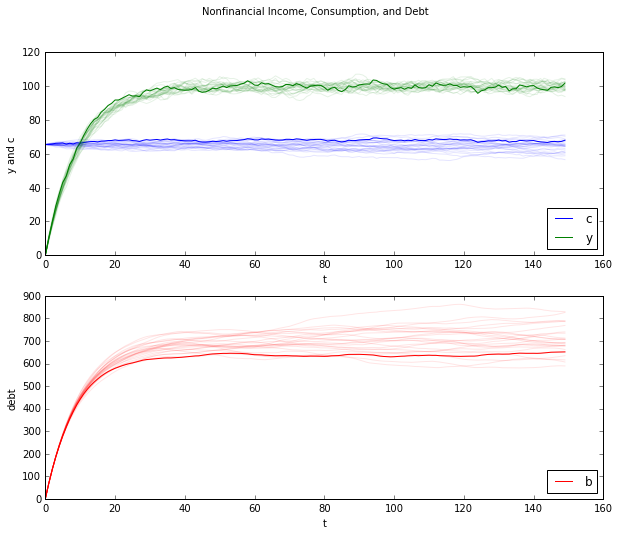

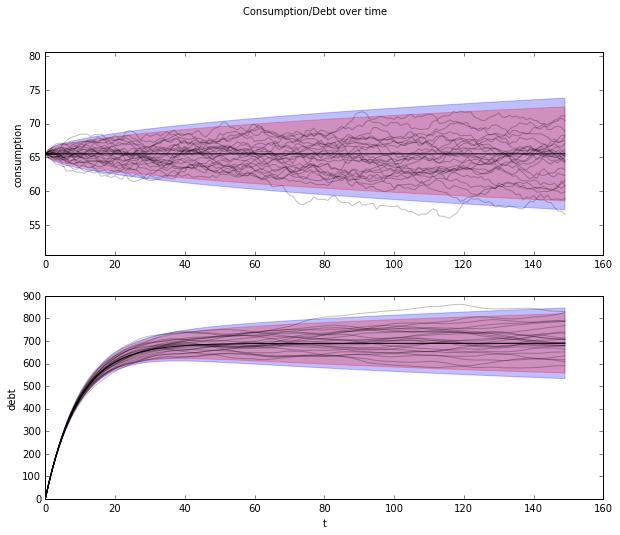

In [12]:
# Creates pictures with initial conditions of 0.0 for y and b
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS, mu_0, sigma_0)
bsim0, csim0, ysim0 = out[:3]
cons_mean0, cons_var0, debt_mean0, debt_var0 = out[3:]

fig_0 = consumption_income_debt_figure(bsim0, csim0, ysim0)
fig_02 = consumption_debt_fanchart(csim0, cons_mean0, cons_var0,
                                   bsim0, debt_mean0, debt_var0)

fig_0.show()

fig_02.show()

#### First example

Here is what is going on in the above graphs.

Because we have set $y_{-1} = y_{-2} = 0$, nonfinancial income $y_t$ starts far below its stationary mean
$\mu_{y, \infty}$ and rises early in each simulation.   

To help interpret the behavior  above graph, recall that we can represent the optimal decision rule for consumption
in terms of the **co-integrating relationship**
$$ (1-\beta) b_t + c_t = (1-\beta) E_t \sum_{j=0}^\infty \beta^j y_{t+j}, $$
For our simulation, we have set initial conditions $b_0 = y_{-1} = y_{-2} = 0$ (please see the code above).
So at time $0$ we have
$$ c_0 = (1-\beta) E_0 \sum_{t=0}^\infty \beta^j y_{t} . $$
This tells us that consumption starts at the value of an annuity from the expected discounted value of nonfinancial
income.  To support that level of consumption, the consumer borrows a lot early on, building up substantial debt.
In fact, he or she incurs so much debt that eventually, in the stochastic steady state, he consumes less each period than his income.  He uses the gap between consumption and income mostly to service the interest payments due on his debt.

Thus, when we look at the panel of debt in the accompanying graph, we see that this is a group of *ex ante* indentical people each of whom  starts  with zero debt.  All of them accumulate debt in anticipation of rising nonfinancial income. The expect their nonfinancial income to rise toward the invariant distribution of income, a consequence of our having started them at  $y_{-1} = y_{-2} = 0$.



### Illustration of cointegration 

The LQ permanent income model is a good one for illustrating the concept of **cointegration**.

The following figure plots realizations of the left side of 
$$ (1-\beta) b_t + c_t = (1-\beta) E_t \sum_{j=0}^\infty \beta^j y_{t+j}, \quad (12) $$
which is called the **cointegrating residual**.

Notice that it equals the right side, namely,  $(1-\beta) E_t \sum_{j=0}^\infty \beta^j y_{t+j}$,
which equals an annuity payment on the expected present value of future income $E_t \sum_{j=0}^\infty \beta^j y_{t+j}$.

Early along a realization, $c_t$ is approximately constant while  $(1-\beta) b_t$ and $(1-\beta) E_t \sum_{j=0}^\infty \beta^j y_{t+j}$ both rise markedly as the household's present value of income  and borrowing rise pretty much together.  


**Note:**  This example illustrates the following point: the definition of cointegration implies that the cointegrating residual is *asymptotically* covariance stationary, not *covariance stationary*.  The cointegrating residual for the specification with zero income and zero debt initially has a notable transient component that dominates its behavior early in the sample. By specifying different initial conditions, we shall remove this transient in our second example to be presented below.


In [13]:
def cointegration_figure(bsim, csim):
    """
    Plots the cointegration
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot((1-beta)*bsim[0, :] + csim[0, :], color="k")
    ax.plot((1-beta)*bsim.T + csim.T, color="k", alpha=.1)

    fig.suptitle("Cointegration of Assets and Consumption")
    ax.set_xlabel("t")
    ax.set_ylabel("")
    
    return fig

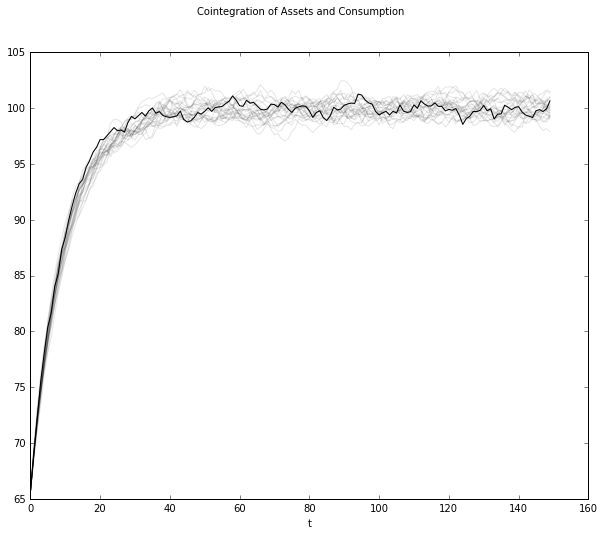

In [14]:
fig = cointegration_figure(bsim0, csim0)
fig.show()



## A    "borrowers and lenders" closed economy

When we set $y_{-1} = y_{-2} = 0$ and $b_0 =0$ in the preceding exercise, we make debt "head north" early in the sample.   Average debt rises and approaches asymptote.  

We can regard these as outcomes of a ``small open economy'' that borrows from abroad at the fixed gross interest rate $R$ in anticipation of rising incomes.  

So with the economic primitives set as above, the economy converges to a steady state in which there is an excess aggregate supply of risk-free loans at a gross interest rate of $R$. This excess supply is filled by ``foreigner lenders'' willing to make those loans.  

We can use virtually the same code to rig a "poor man's Bewley model" in the following way. 

  * as before, we start everyone at $b_0 = 0$.  
  
  * But instead of starting everyone at $y_{-1} = y_{-2} = 0$, we draw $\begin{bmatrix} y_{-1} \cr y_{-2}
  \end{bmatrix}$ from the invariant distribution of the $\{y_t\}$ process.  
  
This rigs a closed economy in which people are borrowing and lending with each other at a gross risk-free
interest rate of $R = \beta^{-1}$.  Here within the group of people being analyzed, risk-free loans are in zero excess supply. We have arranged primitives so that $R = \beta^{-1}$ clears the market for risk-free loans at zero aggregate excess supply.  There is no need for foreigners to lend to our group.  

The following graphs confirm the following outcomes:

  * as before, the consumption distribution spreads out over time. But now there is some initial dispersion because there is  *ex ante* heterogeneity in the initial draws of $\begin{bmatrix} y_{-1} \cr y_{-2}
  \end{bmatrix}$.
  
  * as before, the cross-section distribution of debt spreads out over time.
  
  * Unlike before, the average level of debt stays at zero, reflecting that this is a closed borrower-and-lender economy.
  
  * Now the cointegrating residual seems stationary, and not just asymptotically stationary.  

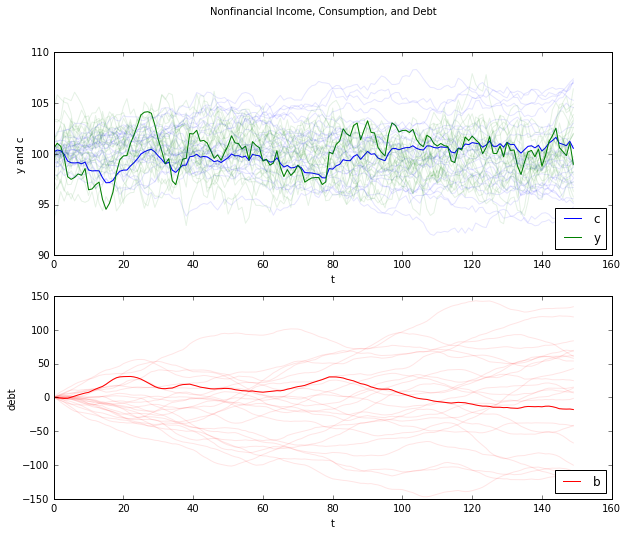

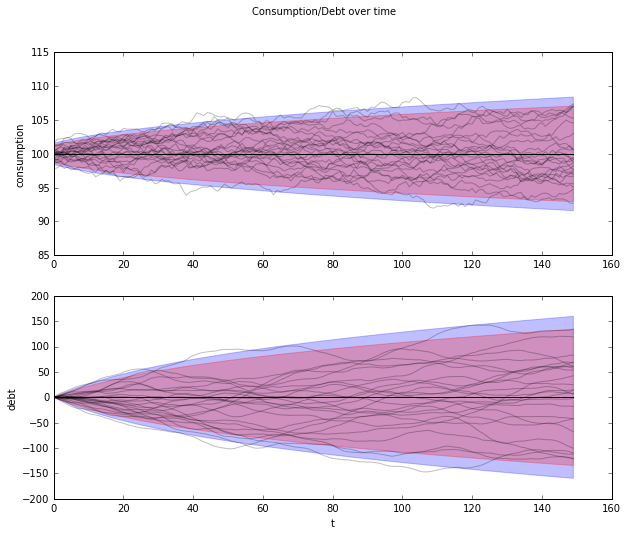

In [15]:
# Creates pictures with initial conditions of 0.0 for  b and y from invariant distribution
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS, mxbewley, sxbewley)
bsimb, csimb, ysimb = out[:3]
cons_meanb, cons_varb, debt_meanb, debt_varb = out[3:]

fig_0 = consumption_income_debt_figure(bsimb, csimb, ysimb)
fig_02 = consumption_debt_fanchart(csimb, cons_meanb, cons_varb,
                                   bsimb, debt_meanb, debt_varb)

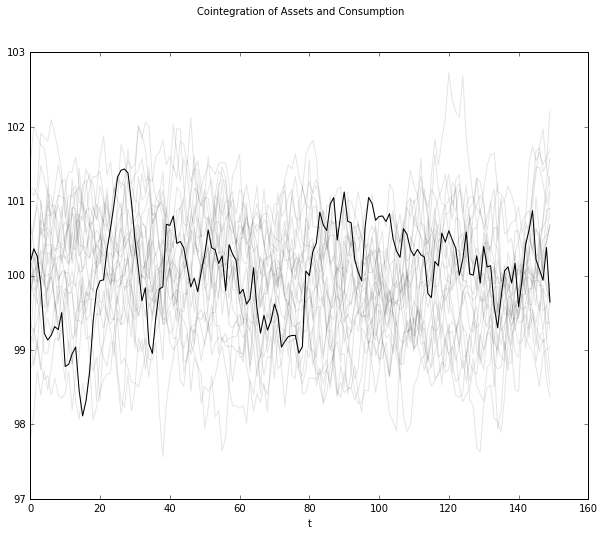

In [16]:
fig = cointegration_figure(bsimb, csimb)
fig.show()